# In this notebook I will:
* Parse the reviewer column into actually useful information
* Go through and split dataframes based on reviews that have text and those that do not (and save the second to their own file)
* Go through and remove reviews that only have advertisements
* Tokenize, lemmatize, remove stop words, and remove instances of words that only show up once that aren't special (words that indicate a condition, medication, side effect, or caregiver role) --> Not trying this last part yet
* Rejoin processed review into a string for BOW analysis
* Save files with processed reviews


* Use an expected value framework to modify the satifaction score with side effect mentions

In [77]:
import pandas as pd
import numpy as np
import glob

# Haven't decided whether I like nltk or spacy better yet
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
stops = stopwords.words('english')
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

# A method to process text in nltk:
# https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

# same process in spacy
# https://spacy.io/usage/linguistic-features

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Just don't have time to learn these right now
#from sklearn.base import TransformerMixin
#from sklearn.pipeline import Pipeline

In [103]:
import matplotlib.pyplot as plt

In [80]:
# Adjusting stop words in spacy to not lose a bunch of negatives for the sentiment analysis
for word in [u'nor',u'none',u'not',u'alone',u'no',u'never',u'cannot',u'always',u'but]:
    nlp.vocab[word].is_stop = False

In [ ]:
# Grabbing original medications/SE dataframe to identify what words are important to keep
def makeListofStr(s: str) -> list:
    List = s[1:-1].split("'")
    List = [string for string in List if string and string != ', ']
    return List

medsDF = pd.read_csv('Medications_SideEffects_brandAndlinks.csv', index_col=0,
                    converters={'Parent links': lambda x: makeListofStr(x), 'Exact medications': lambda x: makeListofStr(x)})

In [25]:
# A function to parse the reviewer information
def parse_reviewer(reviewer):
    # Find name as unique identifier if present
    if reviewer.find(',') != -1:
        name = reviewer[reviewer.find(':')+2:reviewer.find(',')]
    else:
        name = np.NaN
    
    # Find age range as datapoint if present
    if reviewer.find('-') != -1:
        if reviewer.find(',') != -1:
            age = reviewer[reviewer.find(',')+2:reviewer.find(' ', reviewer.find('-'))]
        else:
            age = reviewer[reviewer.find(':')+2:reviewer.find(' ', reviewer.find('-'))]
    else:
        age = np.NaN
        
    # Find gender if present
    if reviewer.find('Male') != -1:
        gender = 'Male'
    elif reviewer.find('Female') != -1:
        gender = 'Female'
    else:
        gender = np.NaN
        
    # Find treatment time
    if reviewer.find('on Treatment') != -1:
        if reviewer.rstrip()[-1] == ')':
            treatment_time = reviewer[reviewer.find('on Treatment for ')+16:reviewer.rfind('(')].strip()
        else:
            treatment_time = reviewer[reviewer.find('on Treatment for ')+16:].rstrip().strip()
    else:
        treatment_time = np.NaN
    
    # Put info in a dictionary that can be made into a dictionary
    reviewer_info = {}
    reviewer_info['Name'] = name
    reviewer_info['Age'] = age
    reviewer_info['Gender'] = gender
    reviewer_info['Length of treatment'] = treatment_time
    
    return reviewer_info

def processReviewerColumn(reviewDF):
    # Parse the reviewer info
    reviewers = []
    for reviewer in reviewDF['reviewer']:
        reviewers.append(parse_reviewer(reviewer))
    reviewersDF = pd.DataFrame(reviewers, index=reviewDF.index)

    # Drop the reviewer column from the original dataframe
    reviewDF = reviewDF.drop(columns=['reviewer'])

    # Add the parsed reviewer info to the original dataframe
    reviewDF = pd.concat([reviewDF, reviewersDF], axis=1)
    
    return reviewDF

In [19]:
# Grabbing all the files I need to process
files = glob.glob('ProcessedReviews/*raw_reviews.csv')
files = [file for file in files if file.find('allconditions') == -1]

In [20]:
# Playing around to see what an empty review looks like
file0 = files[0]
df = pd.read_csv(file0, sep='$', index_col=0)

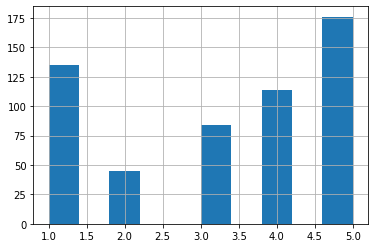

In [142]:
parsedDF = processReviewerColumn(df).dropna(subset=['Comment'])

In [84]:
comments = [(ind,parsedDF.loc[ind]['Comment']) for ind in parsedDF.index]

In [88]:
lengths = [len(com[1]) for com in comments]
longcomment = comments[lengths.index(max(lengths))][1]

In [110]:
def spacyTokenizer(comment):
    doc = nlp(comment.lower().strip())
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':
            tokens.append(token.lemma_)
        
    return tokens

In [96]:
broken_comment = test.split(' ')

In [129]:
spacyTokenizer(longcomment)

['foremost',
 'no',
 'history',
 'drug',
 'reaction',
 'allergy',
 'etc',
 'average',
 'healthy',
 'chick',
 'anxiety',
 'complicated',
 'medication',
 'switch',
 'give',
 'short',
 'term',
 'disability',
 'reason',
 'know',
 'time',
 'go',
 'look',
 'med',
 'hard',
 'go',
 'episode',
 'nausea',
 'point',
 'pull',
 'road',
 'think',
 'vomit',
 'say',
 'medication',
 'work',
 'experience',
 'no',
 'anxiety',
 'attack',
 'pretty',
 'cool',
 'let',
 'tell',
 'surely',
 'need',
 'watch',
 'clock',
 'miss',
 'dose',
 'clock',
 'get',
 'close',
 'meds',
 'time',
 'withdrawl',
 'symptom',
 'med',
 'start',
 'rear',
 'ugly',
 'head',
 'mean',
 'hour',
 'time',
 'normally',
 'take',
 'internal',
 'alarm',
 'clock',
 'sort',
 'read',
 'withdrawl',
 'symptom',
 'completely',
 'accurate',
 'always',
 'describe',
 'throb',
 'brain',
 'zap',
 'work',
 'jut',
 'bad',
 'quickly',
 'debilitating',
 'feeling',
 'miss',
 'keep',
 'head',
 'eye',
 'zap',
 'eye',
 'hurt',
 'kind',
 'zombied',
 'horrible',


In [140]:
# Working on sentiment analysis
# Starting source: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python
# Other source: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

def comment_features(comment):
    document = list(nltk.FreqDist(w for w in spacyTokenizer(comment)))
    document_words = set(document)
    
    features = {}
    for word in document:
        features['contains({})'.format(word)] = (word in document_words)
    return features

def dichotomize_satisfaction(score):
    if score > 3:
        return 'positive'
    else:
        return 'negative'

featuresets = [(comment_features(comment),dichotomize_satisfaction(sat)) for comment, sat in zip(parsedDF['Comment'], parsedDF['Effectiveness'])] 
classifier = nltk.NaiveBayesClassifier.train(featuresets)
classifier.show_most_informative_features(20)

Most Informative Features
      contains(research) = True           negati : positi =      8.0 : 1.0
          contains(blur) = True           negati : positi =      7.7 : 1.0
     contains(nauseated) = True           negati : positi =      7.7 : 1.0
         contains(shake) = True           negati : positi =      7.7 : 1.0
      contains(severely) = True           negati : positi =      7.7 : 1.0
          contains(okay) = True           negati : positi =      6.3 : 1.0
         contains(worse) = True           negati : positi =      6.3 : 1.0
          contains(zero) = True           negati : positi =      6.3 : 1.0
     contains(beginning) = True           negati : positi =      6.3 : 1.0
        contains(remove) = True           negati : positi =      6.3 : 1.0
         contains(happy) = True           positi : negati =      5.1 : 1.0
       contains(violent) = True           negati : positi =      4.9 : 1.0
   contains(alternative) = True           negati : positi =      4.9 : 1.0

In [134]:
featuresets

[({'contains(low)': True,
   'contains(dose)': True,
   'contains(venlafaxine)': True,
   'contains(year)': True,
   'contains(feel)': True,
   'contains(great)': True,
   'contains(rarely)': True,
   'contains(suffer)': True,
   'contains(anxiety)': True,
   'contains(like)': True,
   'contains(past)': True},
  'positive'),
 ({'contains(dose)': True,
   'contains(range)': True,
   'contains(day)': True,
   'contains(find)': True,
   'contains(emotion)': True,
   'contains(narrow)': True,
   'contains(unfortunately)': True,
   'contains(dull)': True,
   'contains(high)': True,
   'contains(cause)': True,
   'contains(ed)': True,
   'contains(crazy)': True,
   'contains(dream)': True,
   'contains(difficult)': True,
   'contains(no)': True,
   'contains(longer)': True,
   'contains(take)': True},
  'negative'),
 ({'contains(help)': True,
   'contains(depression)': True,
   'contains(anxiety)': True,
   'contains(cost)': True,
   'contains(overwhelming)': True,
   'contains(nausea)': Tru

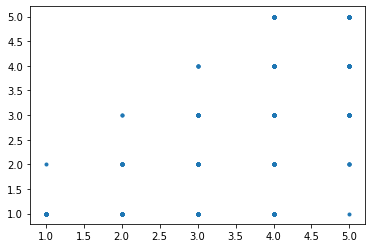

In [105]:
# Can effectiveness be a feature?
plt.scatter(parsedDF['Effectiveness'], parsedDF['Satisfaction'], marker='.')